In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import warnings

# plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from datetime import datetime
import backtrader as bt
import pandas as pd 
import yfinance as yf

In [4]:
class SmaSignal(bt.Signal):
    params = (('period', 20), )
    
    def __init__(self):
        self.lines.signal = self.data - bt.ind.SMA(period=self.p.period)

In [5]:
data = bt.feeds.PandasData(dataname=yf.download('VOO', '2018-01-01', '2022-02-22'))

[*********************100%***********************]  1 of 1 completed


In [6]:
cerebro = bt.Cerebro(stdstats = False)

cerebro.adddata(data)
cerebro.broker.setcash(1000.0)
cerebro.add_signal(bt.SIGNAL_LONG, SmaSignal)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

In [7]:
print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.run()
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value: 1000.00
Final Portfolio Value: 1056.93


<IPython.core.display.Javascript object>


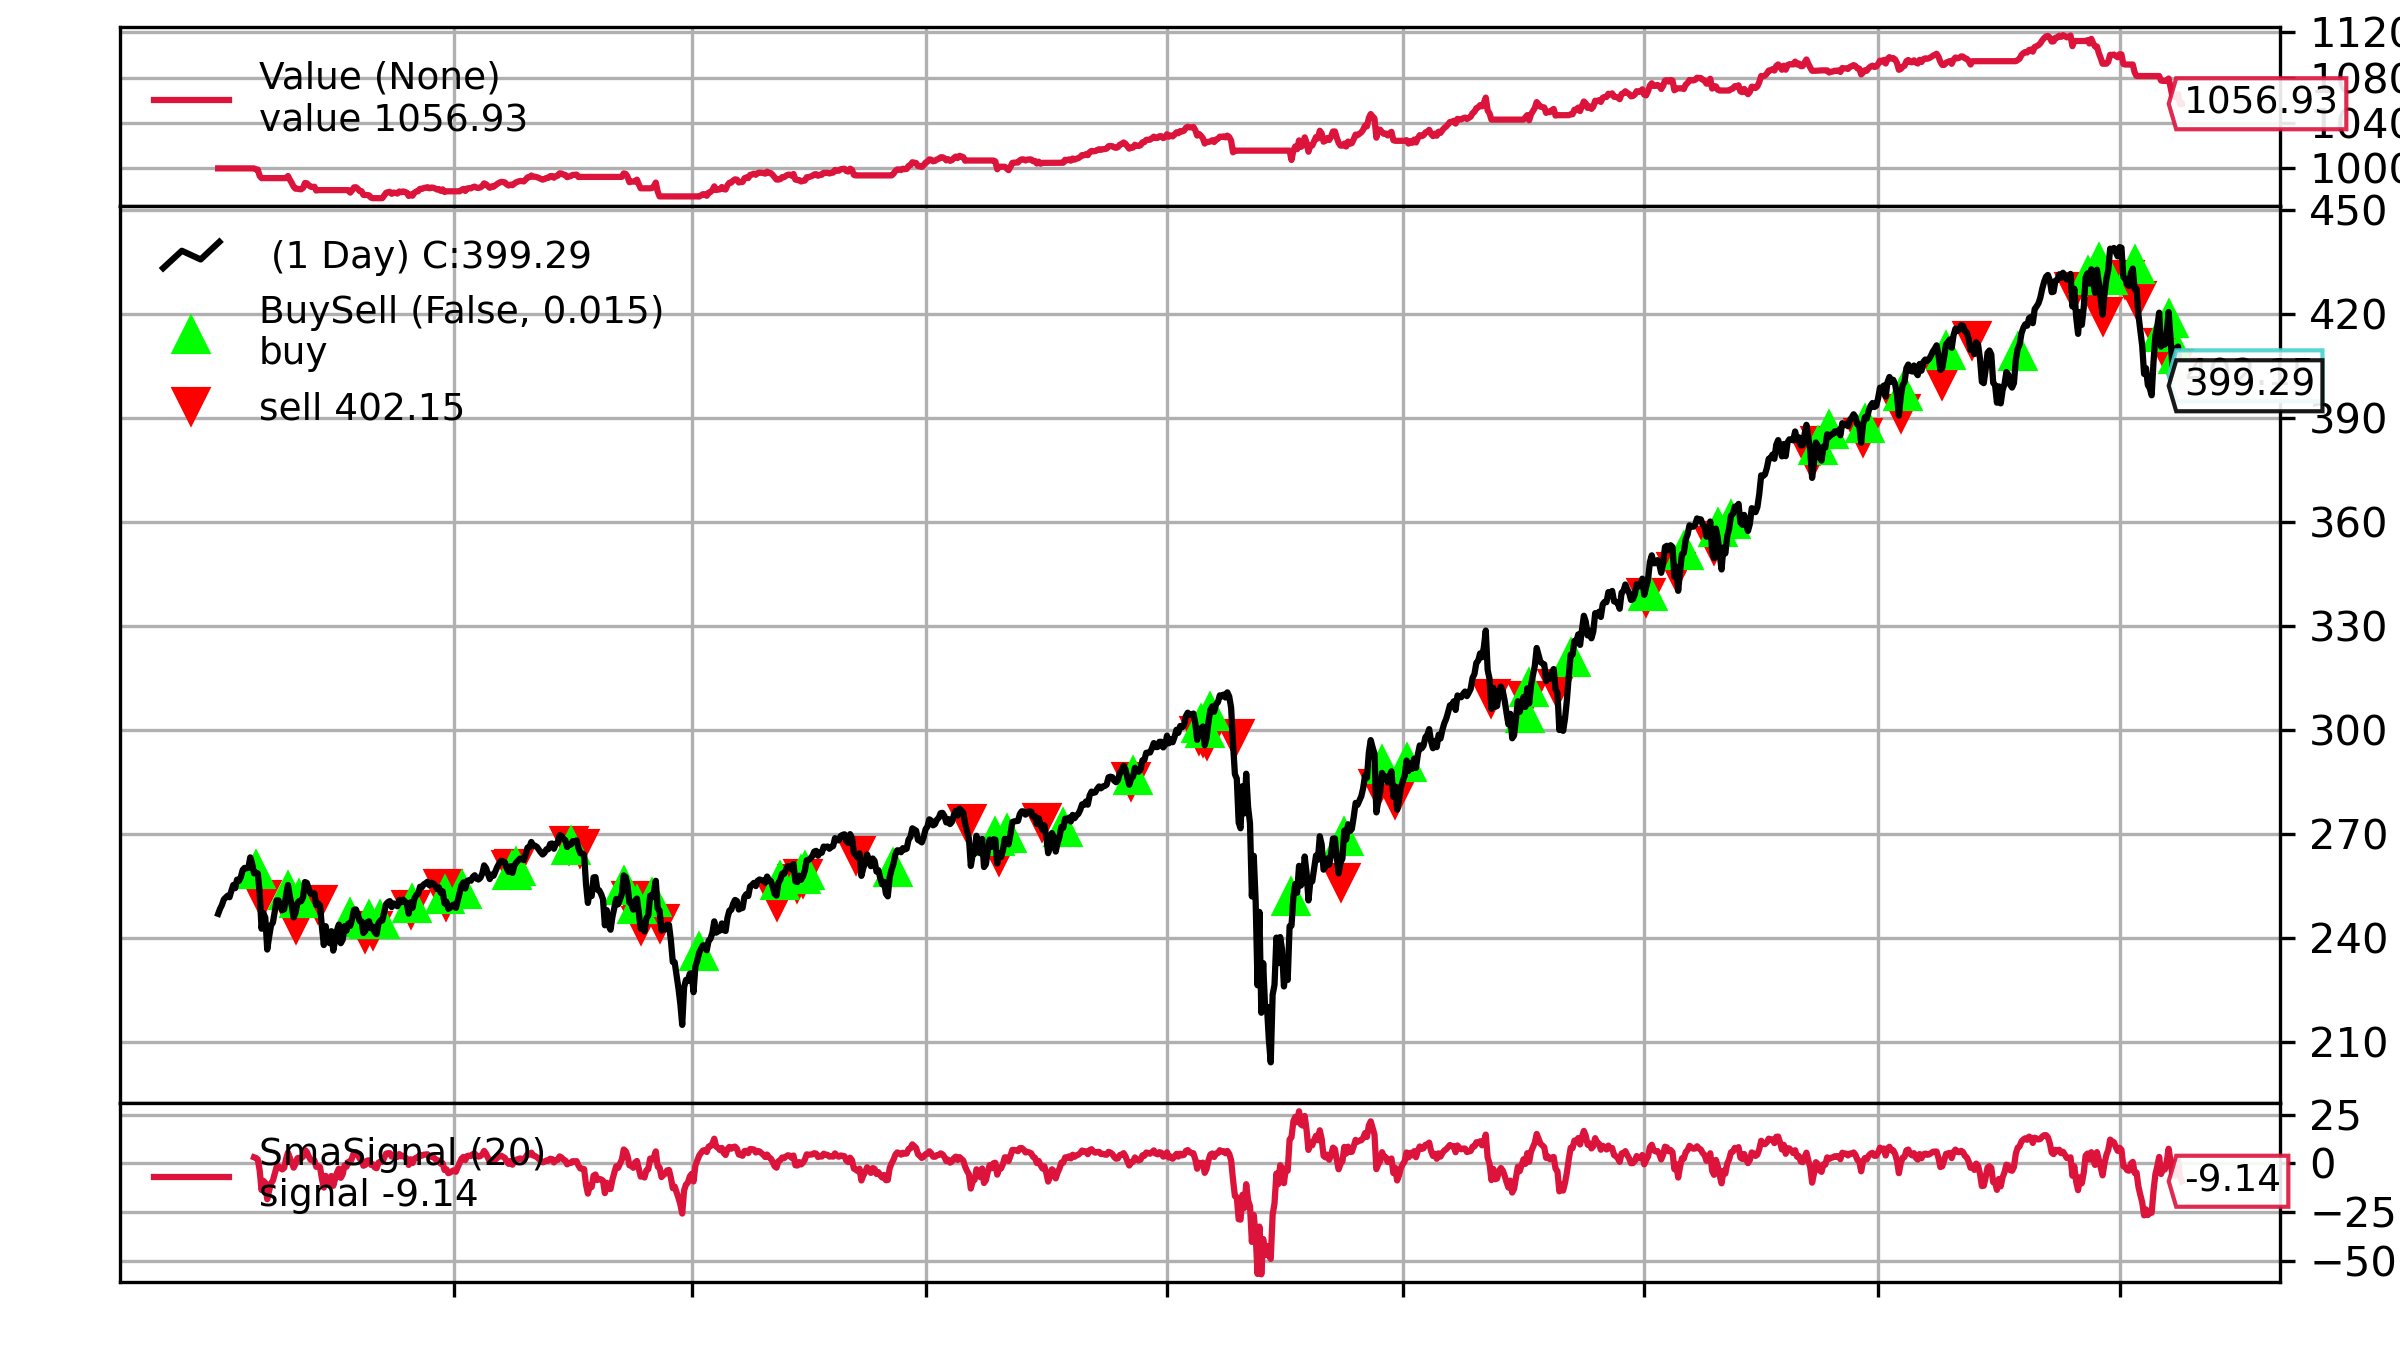

[[<Figure size 2400x1350 with 3 Axes>]]

In [8]:
cerebro.plot(iplot=True, volume=False)

In [9]:
class SmaStrategy(bt.Strategy):
    params = (('ma_period', 20), )

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close

        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

        # add a simple moving average indicator
        self.sma = bt.ind.SMA(self.datas[0],
                              period=self.params.ma_period)
        
    def log(self, txt):
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return
 # check if there is already a position
        if not self.position:
            # buy condition
            if self.data_close[0] > self.sma[0]:
                self.log(f'BUY CREATED --- Price: {self.data_close[0]:.2f}')
                self.order = self.buy()
        else:
            # sell condition
            if self.data_close[0] < self.sma[0]:            
                self.log(f'SELL CREATED --- Price: {self.data_close[0]:.2f}')
                self.order = self.sell()

In [10]:
cerebro = bt.Cerebro(stdstats = False)

cerebro.adddata(data)
cerebro.broker.setcash(1000.0)
cerebro.addstrategy(SmaStrategy)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

In [11]:
print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.run()
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value: 1000.00
2018-01-30, BUY CREATED --- Price: 258.75
2018-01-31, BUY EXECUTED --- Price: 259.83, Cost: 259.83, Commission: 0.00
2018-02-02, SELL CREATED --- Price: 253.19
2018-02-05, SELL EXECUTED --- Price: 251.26, Cost: 259.83, Commission: 0.00
2018-02-05, OPERATION RESULT --- Gross: -8.57, Net: -8.57
2018-02-23, BUY CREATED --- Price: 252.49
2018-02-26, BUY EXECUTED --- Price: 253.56, Cost: 253.56, Commission: 0.00
2018-03-01, SELL CREATED --- Price: 246.05
2018-03-02, SELL EXECUTED --- Price: 244.24, Cost: 253.56, Commission: 0.00
2018-03-02, OPERATION RESULT --- Gross: -9.32, Net: -9.32
2018-03-05, BUY CREATED --- Price: 250.20
2018-03-06, BUY EXECUTED --- Price: 251.22, Cost: 251.22, Commission: 0.00
2018-03-19, SELL CREATED --- Price: 249.61
2018-03-20, SELL EXECUTED --- Price: 249.99, Cost: 251.22, Commission: 0.00
2018-03-20, OPERATION RESULT --- Gross: -1.23, Net: -1.23
2018-04-12, BUY CREATED --- Price: 244.28
2018-04-13, BUY EXECUTED --- Price: 245.84

In [ ]:
# %load backtrader_sma_strategy_optimization.py
from datetime import datetime
import backtrader as bt

# Create a Stratey
class SmaStrategy(bt.Strategy):
    params = (('ma_period', 20),)

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close

        # keep track of pending orders
        self.order = None

        # add a simple moving average indicator
        self.sma = bt.ind.SMA(self.datas[0], period=self.params.ma_period)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        # set no pending order
        self.order = None

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            # buy condition
            if self.data_close[0] > self.sma[0]:
                self.order = self.buy()
        else:
            # sell condition
            if self.data_close[0] < self.sma[0]:
                self.order = self.sell()

    def stop(self):
        self.log(f'(ma_period = {self.params.ma_period:2d}) --- Terminal Value: {self.broker.getvalue():.2f}')
        
    data = bt.feeds.PandasData(dataname=yf.download('VOO', '2021-02-22', '2022-02-22'))
    
    # create a Cerebro entity
cerebro = bt.Cerebro(stdstats = False)

# set up the backtest
cerebro.adddata(data)
cerebro.optstrategy(SmaStrategy, ma_period=range(10, 31))
cerebro.broker.setcash(1000.0)
cerebro.run(maxcpus=4)
        

[*********************100%***********************]  1 of 1 completed


In [ ]:
import backtrader as bt
import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
class BBand_Strategy(bt.Strategy):
    params = (('period', 20),
              ('devfactor', 2.0),)

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close
        self.data_open = self.datas[0].open

        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

        # add Bollinger Bands indicator and track the buy/sell signals
        self.b_band = bt.ind.BollingerBands(self.datas[0], 
                                            period=self.p.period, 
                                            devfactor=self.p.devfactor)
        self.buy_signal = bt.ind.CrossOver(self.datas[0], 
                                           self.b_band.lines.bot)
        self.sell_signal = bt.ind.CrossOver(self.datas[0], 
                                            self.b_band.lines.top)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(
                    f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}'
                )

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')

            # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    def next_open(self):
        if not self.position:
            if self.buy_signal > 0:
                # calculate the max number of shares ('all-in')
                size = int(self.broker.getcash() / self.datas[0].open)
                # buy order
                self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy(size=size)
        else:
            if self.sell_signal < 0:
                # sell order
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)

In [ ]:
data = bt.feeds.PandasData(dataname=yf.download('VOO', '2021-02-22', '2022-02-22'))

In [ ]:
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)

cerebro.addstrategy(BBand_Strategy)
cerebro.adddata(data)
cerebro.broker.setcash(10000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='time_return')

In [ ]:
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

In [ ]:
cerebro.plot(iplot=True, volume=False)